# Определение перспективного тарифа для телеком-компании


<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Изучение-данных-из-файла" data-toc-modified-id="Изучение-данных-из-файла-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Изучение данных из файла</a></span><ul class="toc-item"><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Проверка гипотез" data-toc-modified-id="Проверка гипотез-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка гипотез</a></span></li><li><span><a <li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a 

Описание проекта

Компания «Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Нужно сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.


Описание данных

Таблица users (информация о пользователях):

user_id — уникальный идентификатор пользователя

first_name — имя пользователя

last_name — фамилия пользователя

age — возраст пользователя (годы)

reg_date — дата подключения тарифа (день, месяц, год)

churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)

city — город проживания пользователя

tarif — название тарифного плана

Таблица calls (информация о звонках):

id — уникальный номер звонка

call_date — дата звонка

duration — длительность звонка в минутах

user_id — идентификатор пользователя, сделавшего звонок

Таблица messages (информация о сообщениях):

id — уникальный номер сообщения

message_date — дата сообщения

user_id — идентификатор пользователя, отправившего сообщение

Таблица internet (информация об интернет-сессиях):

id — уникальный номер сессии

mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)

session_date — дата интернет-сессии

user_id — идентификатор пользователя

Таблица tariffs (информация о тарифах):

tariff_name — название тарифа

rub_monthly_fee — ежемесячная абонентская плата в рублях

minutes_included — количество минут разговора в месяц, включённых в абонентскую плату

messages_included — количество сообщений в месяц, включённых в абонентскую плату

mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)

rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)

rub_per_message — стоимость отправки сообщения сверх тарифного пакета

rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Изучение данных из файла

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy import stats as st
import datetime
df_calls = pd.read_csv('/datasets/calls.csv')
df_internet = pd.read_csv('/datasets/internet.csv')
df_messages = pd.read_csv('/datasets/messages.csv')
df_tariffs = pd.read_csv('/datasets/tariffs.csv')
df_users = pd.read_csv('/datasets/users.csv')
#открыли и записали файлы

In [2]:
display(df_calls.head(5))
df_calls.info()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [3]:
# Пропущенных значений нет. 
#Нужно привести дату к нужному формату, а также вынести месяц в отдельный столбец, чтобы дальше было удобно рпботать с данными.
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')
df_calls['month'] = pd.DatetimeIndex(df_calls['call_date']).month

In [4]:
display(df_internet.head(5))
df_internet.info()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [5]:
#Пропущенных значений нет.
# Переведем даты в нуужный формат, добавим столбец с месяцем.
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')
df_internet['month'] = pd.DatetimeIndex(df_internet['session_date']).month

In [6]:
display(df_messages.head(5))
df_messages.info()


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [7]:
#Пропущенных значений нет.
# Переведем даты в нуужный формат, добавим столбец с месяцем.
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d')
df_messages['month'] = pd.DatetimeIndex(df_messages['message_date']).month

In [8]:
df_tariffs = df_tariffs.rename(columns={'tariff_name':'tariff'})
#заменим имя столбца для удобства
display(df_tariffs.head())

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [9]:
display(df_users.head(5))
df_users.info()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [10]:
# churn_date - дата прекращения пользования тарифом(если значение пропущено, то тариф ещё действовал на момент выгрузки данных)

#Пропущенные значения в churn_date. Неверный формат данных в churn_date, reg_date.
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format = '%Y-%m-%d')
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format = '%Y-%m-%d')

df_users

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaT,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaT,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaT,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


Вывод :

В данном блоке мы изучили данные, у нас есть 5 таблиц с данными по звонкам, интернету, пользователям, тарифам и сообщениям. Мы изменили типы данных, а также добавили столбцы с месяцами, чтобы далее можно было заняться предобработкой и объединить все таблицы в одну, удобную для работы. Из общей таблицы мы и будем рассчитывать дальнейшие данные и работать с ними.

## Предобработка данных

In [11]:
df_users = df_users.merge(df_tariffs, on = 'tariff', how = 'left')
df_users.head(5)
# начальная общая таблица

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,50,15360,500,550,200,3,3
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,50,15360,500,550,200,3,3
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,1000,30720,3000,1950,150,1,1
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,1000,30720,3000,1950,150,1,1


In [12]:
calls_grouped = df_calls.pivot_table(index = ['user_id','month'], values = 'duration', aggfunc = 'sum').reset_index()
calls_grouped.columns = ['user_id', 'month', 'duration']
display(calls_grouped.head(5))
# группируем данные по звонкам по месяцам

,user_id,month,duration
0,1000,5,150.06
1,1000,6,158.90
2,1000,7,318.80
3,1000,8,389.87
4,1000,9,440.14


In [13]:
internet_grouped = df_internet.pivot_table(index = ['user_id','month'], values = 'mb_used', aggfunc = 'sum').reset_index()
internet_grouped.columns = ['user_id', 'month', 'mb_used']
display(internet_grouped.head(5))
# группируем данные по интернету по месяцам

,user_id,month,mb_used
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91


In [14]:
messages_grouped = df_messages.pivot_table(index = ['user_id','month'], values = 'message_date', aggfunc = 'count').reset_index()
messages_grouped.columns = ['user_id', 'month', 'messages']
display(messages_grouped.head(5))
# группируем данные по sms по месяцам

,user_id,month,messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


In [15]:
df = internet_grouped.merge(messages_grouped, on = ['user_id', 'month'], how = 'outer')
df = df.merge(calls_grouped, on = ['user_id', 'month'], how = 'outer')
df = df.merge(df_users, on = 'user_id', how = 'outer')
df.head(5)
#соединили все таблицы в одну

,user_id,month,mb_used,messages,duration,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5.0,2253.49,22.0,150.06,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,6.0,23233.77,60.0,158.90,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,7.0,14003.64,75.0,318.80,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,8.0,14055.93,81.0,389.87,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,9.0,14568.91,57.0,440.14,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1


In [16]:
# есть пропущенные значения, заменим их на 0, также заменим месяц и смс на тип int()
#удалим строки, где в месяце пропущееное значение
df = df.dropna(subset = ['month'])
df['mb_used'] = df['mb_used'].fillna(0)
df['messages'] = df['messages'].fillna(0).astype('int')
df['duration'] = df['duration'].fillna(0)
df['month']=df['month'].astype('int')
#df.info()

In [17]:
#для расчетов нам удобней перевести мб в гб, так как будет удобней считать.
#в 1 ГБ 1024 мб, разделим столбец на 1024
df['mb_used']= df['mb_used']/1024
df = df.rename(columns = {'mb_used' : 'gb_used'})
df['mb_per_month_included']= df['mb_per_month_included']/1024
df = df.rename(columns = {'mb_per_month_included' : 'gb_per_month_included'})

df.head(5)

,user_id,month,gb_used,messages,duration,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,2.200674,22,150.06,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
1,1000,6,22.689229,60,158.90,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
2,1000,7,13.675430,75,318.80,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
3,1000,8,13.726494,81,389.87,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
4,1000,9,14.227451,57,440.14,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1


In [18]:
#округлим столбцы с длительностью звонков и гб в большую сторону.
df['duration'] = np.ceil(df['duration']).astype('int')
df['gb_used'] = np.ceil(df['gb_used']).astype('int')

#Создаем столбцы, в которые попадёт сумма выручки компании при превышении клиентом трафика:
df['revenue_calls'] = (df['duration'] - df['minutes_included']) * df['rub_per_minute']
df['revenue_internet'] = (df['gb_used'] - df['gb_per_month_included']) * df['rub_per_gb'] 
df['revenue_messages'] = (df['messages'] - df['messages_included']) * df['rub_per_message']
# Если превышения нет, оставим в этих столбцах нули:
df.loc[df['revenue_calls'] < 0, 'revenue_calls'] = 0
df.loc[df['revenue_internet'] < 0, 'revenue_internet'] = 0
df.loc[df['revenue_messages'] < 0, 'revenue_messages'] = 0
#Итоговая выручка:
df['revenue_month'] = df['rub_monthly_fee'] + df['revenue_calls'] + df['revenue_internet'] + df['revenue_messages']
df.head(5)

,user_id,month,gb_used,messages,duration,age,churn_date,city,first_name,last_name,...,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,revenue_calls,revenue_internet,revenue_messages,revenue_month
0,1000,5,3,22,151,52,NaT,Краснодар,Рафаил,Верещагин,...,30.0,3000,1950,150,1,1,0,0.0,0,1950.0
1,1000,6,23,60,159,52,NaT,Краснодар,Рафаил,Верещагин,...,30.0,3000,1950,150,1,1,0,0.0,0,1950.0
2,1000,7,14,75,319,52,NaT,Краснодар,Рафаил,Верещагин,...,30.0,3000,1950,150,1,1,0,0.0,0,1950.0
3,1000,8,14,81,390,52,NaT,Краснодар,Рафаил,Верещагин,...,30.0,3000,1950,150,1,1,0,0.0,0,1950.0
4,1000,9,15,57,441,52,NaT,Краснодар,Рафаил,Верещагин,...,30.0,3000,1950,150,1,1,0,0.0,0,1950.0


 Итоги:
 
 Сгруппирована таблица по прибыли компании от превышения пользвателями тарифного плана. 
 Высчитана прибыль отдельно за каждый месяц по смс, звонкам и интернету, а также общая прибыль.

## Исследовательский анализ данных

Задача : Выяснить сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. Посчитать среднее количество, дисперсию и стандартное отклонение. Построить гистограммы. Опишите распределения.

smart    2229
ultra     985
Name: tariff, dtype: int64


<AxesSubplot:title={'center':'Соотношение тарифов'}, ylabel='tariff'>

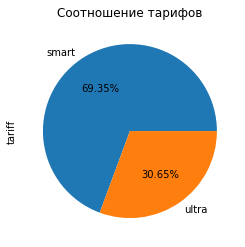

In [19]:
#Посмотрим сколько человек каким тарифом пользуются.
print(df['tariff'].value_counts())
df['tariff'].value_counts().plot(kind = 'pie', title = 'Соотношение тарифов',autopct='%1.2f%%')

Исходя из данных, люди предпочитают пользоваться тарифом Smart, почти 70% из общей выборки.

In [20]:
# возьмем два среза по тарифам
smart = df[df['tariff'] == 'smart']
ultra = df[df['tariff'] == 'ultra']
smart.head(5)


,user_id,month,gb_used,messages,duration,age,churn_date,city,first_name,last_name,...,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,revenue_calls,revenue_internet,revenue_messages,revenue_month
8,1001,11,18,0,409,41,NaT,Москва,Иван,Ежов,...,15.0,500,550,200,3,3,0,600.0,0,1150.0
9,1001,12,14,0,392,41,NaT,Москва,Иван,Ежов,...,15.0,500,550,200,3,3,0,0.0,0,550.0
10,1002,6,11,4,111,59,NaT,Стерлитамак,Евгений,Абрамович,...,15.0,500,550,200,3,3,0,0.0,0,550.0
11,1002,7,18,11,205,59,NaT,Стерлитамак,Евгений,Абрамович,...,15.0,500,550,200,3,3,0,600.0,0,1150.0
12,1002,8,20,13,270,59,NaT,Стерлитамак,Евгений,Абрамович,...,15.0,500,550,200,3,3,0,1000.0,0,1550.0


In [21]:
#средний доход с 1 пользователя по тарифам
print(smart['revenue_month'].mean())
print(ultra['revenue_month'].mean())


1257.5886047554957
2070.1522842639592


In [22]:
#медианные значения доходности по тарифам
print(smart['revenue_month'].median())
print(ultra['revenue_month'].median())


962.0
1950.0


In [23]:
#посмотрим значения для тарифа smart 
display(smart[['duration', 'messages', 'gb_used']].describe())

#посмотрим значения для тарифа ultra 
display(ultra[['duration', 'messages', 'gb_used']].describe())
# также просчитаем дисперсию по каждому пункту тарифа
print('Дисперсия тарифа  smart :\n',
      np.var(smart[['duration', 'messages', 'gb_used']]),'.')
print('Дисперсия тарифа  ultra :\n', 
      np.var(ultra[['duration', 'messages', 'gb_used']]),'.')


,duration,messages,gb_used
count,2229.000000,2229.000000,2229.000000
mean,394.922387,33.384029,16.328847
std,179.980292,28.227876,5.747061
min,0.000000,0.000000,0.000000
25%,268.000000,10.000000,13.000000
50%,398.000000,28.000000,17.000000
75%,516.000000,51.000000,20.000000
max,1355.000000,143.000000,38.000000


,duration,messages,gb_used
count,985.000000,985.000000,985.000000
mean,497.547208,49.363452,19.494416
std,299.929524,47.804457,9.853511
min,0.000000,0.000000,0.000000
25%,268.000000,6.000000,12.000000
50%,489.000000,38.000000,19.000000
75%,712.000000,79.000000,27.000000
max,1579.000000,224.000000,49.000000


Дисперсия тарифа  smart :
 duration    32378.373070
messages      796.455483
gb_used        33.013887
dtype: float64 .
Дисперсия тарифа  ultra :
 duration    89866.391934
messages     2282.946075
gb_used        96.993116
dtype: float64 .


Можно сделать вывод.

По тарифу smart в среднем за месяц пользователи тратят:

1) 395 минут разговора

2) 33 смс

3) 16 ГБ интернета

Стандартное отклонение :

1) Минут разговора - 180

2) Смс - 28

3) Интернет - 5,7 ГБ

Дисперсия тарифа  smart по минутам : 32378.373070 . 

Дисперсия тарифа  smart по смс : 796.455483 .

Дисперсия тарифа  smart по ГБ : 33.013887 .

По тарифу ultra в среднем за месяц пользователи тратят:

1) 498 минут разговора

2) 49 смс

3) 20 ГБ интернета

Стандартное отклонение :

1) Минут разговора - 300

2) Смс - 48

3) Интернет - 10 ГБ

Дисперсия тарифа  ultra по минутам : 89866.391934 . 

Дисперсия тарифа  ultra по смс : 2282.946075 . 

Дисперсия тарифа  ultra по ГБ : 96.993116 .



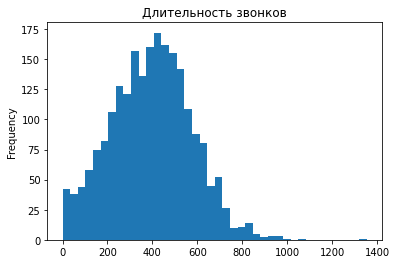

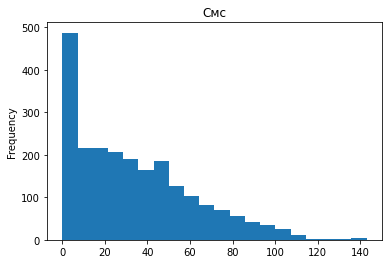

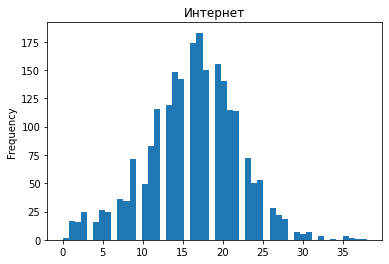

In [24]:
#Построим гистограммы и посмотрим на распределения. Тариф smart.
smart['duration'].plot(kind = 'hist',bins=40, title = 'Длительность звонков')
plt.show()
smart['messages'].plot(kind = 'hist',bins=20, title = 'Смс')
plt.show()
smart['gb_used'].plot(kind = 'hist',bins=50, title = 'Интернет')
plt.show()

На графике длительности минут нормальное распределение. 

На графике смс распределение Пуассона.

На графике интернета нормальное распределение.

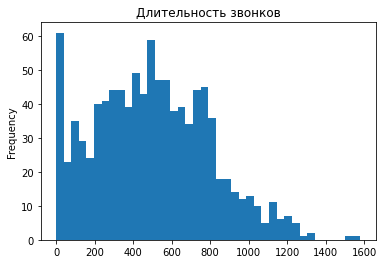

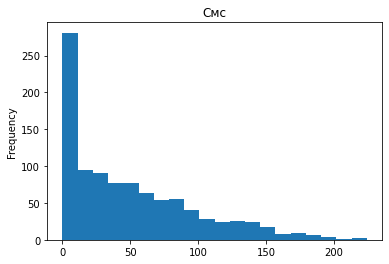

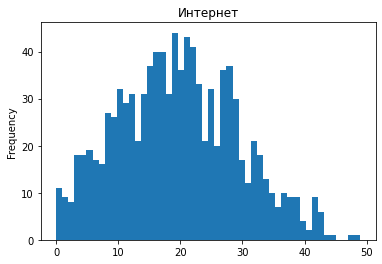

In [25]:
#Построим гистограммы и посмотрим на распределения. Тариф ultra.
ultra['duration'].plot(kind = 'hist',bins=40, title = 'Длительность звонков')
plt.show()
ultra['messages'].plot(kind = 'hist',bins=20, title = 'Смс')
plt.show()
ultra['gb_used'].plot(kind = 'hist',bins=50, title = 'Интернет')
plt.show()

На графике длительности минут нормальное распределение. 

На графике смс распределение Пуассона.

На графике интернета нормальное распределение.

Вывод :

Люди больше предпочитают пользоваться тарифом Smart, почти 70% из общей выборки.
Мы сделали срезы по тарифам и нашли сколько в среднем люди тратят по каждому тарифу в месяц. Также рассчитали дисперсию по каждому тарифу.
Можно заметить, что пользователи тарифа ultra не тратят весь базовый пакет минут и количества смс, в отличие от тарифа smart.
А также пользователи тарифа Ultra в основном переплачивают за интернет.
В среднем разница медианных значений дохода с разных тарифов отличается ~1000 в пользу тарифа ultra.
То есть медианное и среднее значение дохода у абонентов тарифа ultra выше, что дает нам понять о прибыльности тарифа.


## Проверка гипотез

1 Гипотеза. 

H0 = Средняя выручка пользователей тарифов «Ультра» и «Смарт» равна.

H1 = Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

Будем использовать метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам.(ttest Стьюдента)


In [26]:
#проверяем гипотезу
alpha = 0.05
result_one = st.ttest_ind (smart['revenue_month'], ultra['revenue_month'], equal_var = False)
print('p-значение:',result_one.pvalue)
if result_one.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть гипотезу')

p-значение: 6.179723168444486e-274
Отвергаем нулевую гипотезу


p-значение очень маленькое, получается, что нулевая гипотеза отвергается, а альтернативная гипотеза не отвергается. 
Вероятность случайного совпадения средних наших выборок очень маленькое.

Вывод : Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

2 Гипотеза. 

H0 = Средняя выручка пользователей из Москвы равна выручке пользователей из других регионов.

H1 = Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Будем также использовать метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам.(ttest Стьюдента).

In [27]:
#создадим таблицы для пользователей из Москвы и из других регионов
city_msk = df[df['city'] == 'Москва']
city_other =  df[df['city'] != 'Москва']
#проверяем гипотезу
result_two = st.ttest_ind (city_msk['revenue_month'], city_other['revenue_month'], equal_var = False)
print('p-значение:',result_two.pvalue)
if result_two.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть гипотезу')

p-значение: 0.46532858228722906
Не получилось отвергнуть гипотезу


Значение pvalue почти 0,5, вероятность случайного совпадения средних наших выборок вполне вероятно. Поэтому нулевая гипотеза не отвергается.

Вывод : Средняя выручка пользователей из Москвы равна выручке пользователей из других регионов.

## Общий вывод

Мы рассчитали из таблиц все необходимые средние значения израсходованных минут, мегабайт и сообщений, а также прибыль по ним по каждому месяцу и посчитали среднюю прибыль для компании по тарифам с 1 человека. Далее мы разделили всех клиентов по тарифным группам и проверили правильность наших гипотез.


# Проанализировав выборку по абонентам можно сделать вывод :

1) Пользователи тарифа Smart часто не укладываются в лимиты тарифа, но на доп услуги тратят в среднем меньше суммы абонентской платы тарифа Ultra.

2) Пользователи тарифа Ultra в основном переплачивают за интернет.

3) Люди предпочитают пользоваться тарифом Smart, почти 70% из общей выборки.

4) Проверяя гипотезы, мы обнаружили, что средняя выручка пользователей тарифов Ultra и Smart различаются.

5) Проверяя гипотезы, мы обнаружили, что средняя выручка пользователей из Москвы равна выручке пользователей из других регионов.

Рекламный бюджет выгоднее всего перераспределить в пользу тарифа ultra, так как медианное и среднее значение дохода у абонентов тарифа ultra выше.

В среднем «Мегалайн» от одного пользователя в месяц получает 2070 рублей(ultra) и 1258 рублей (smart).


